In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

In [2]:
df = pd.read_csv('german_credit_data.csv').drop(['Unnamed: 0'], axis=1)

In [3]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [5]:
# Пустые значения заполним "средним" значением
df = df.fillna('moderate')

# попробуем пронумеровать по возрастанию значения типа 'little', 'rich' и т.д.
df['Checking account'] = df['Checking account'].replace(['little','moderate','rich'], [1, 2, 3])
df['Saving accounts'] = df['Saving accounts'].replace(['little','moderate','quite rich', 'rich'], [1, 2, 3, 4])

# Допустим мы оцениваем вероятность того, что клиента НЕ ждёт дефолт, т.е. он будет достаточно платёжеспособен.
# Меньшим весом будет обладать тот человек, который снимает жилье, затем, который имеет собственное, 
# а затем, который проживает бесплатно.
df['Housing'] = df['Housing'].replace(['rent','own', 'free'], [1, 2, 3])
df['Sex'] = df['Sex'].replace(['male','female'], [1, 2])

In [6]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,2,2,1,1169,6,radio/TV
1,22,2,2,2,1,2,5951,48,radio/TV
2,49,1,1,2,1,2,2096,12,education
3,45,1,2,3,1,1,7882,42,furniture/equipment
4,53,1,2,3,1,1,4870,24,car


In [7]:
# Посмотрим среднюю величину кредита в зависимости от категории покупки
purposes_means = []
for purpose in df['Purpose'].unique():
    res = purpose, np.mean(df[df['Purpose'] == purpose]['Credit amount'])
    purposes_means.append(res)
    print(res)

('radio/TV', 2487.6535714285715)
('education', 2879.2033898305085)
('furniture/equipment', 3066.988950276243)
('car', 3768.192878338279)
('business', 4158.041237113402)
('domestic appliances', 1498.0)
('repairs', 2728.090909090909)
('vacation/others', 8209.333333333334)


In [8]:
# Пронумеруем Purpose в зависимости от средней величины кредита
purposes_means = np.array(purposes_means)
sorted_purposes = purposes_means[purposes_means[:, 1].argsort()][:, 0]
df['Purpose'] = df['Purpose'].replace(sorted_purposes, [i+1 for i in range(len(sorted_purposes))])

In [9]:
sorted_purposes

array(['domestic appliances', 'radio/TV', 'repairs', 'education',
       'furniture/equipment', 'car', 'business', 'vacation/others'],
      dtype='<U32')

In [10]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,2,2,1,1169,6,2
1,22,2,2,2,1,2,5951,48,2
2,49,1,1,2,1,2,2096,12,4
3,45,1,2,3,1,1,7882,42,5
4,53,1,2,3,1,1,4870,24,6


In [11]:
# Используем StandardScaler для нормализации данных.
scaler = StandardScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(df), 
    columns=df.columns
)

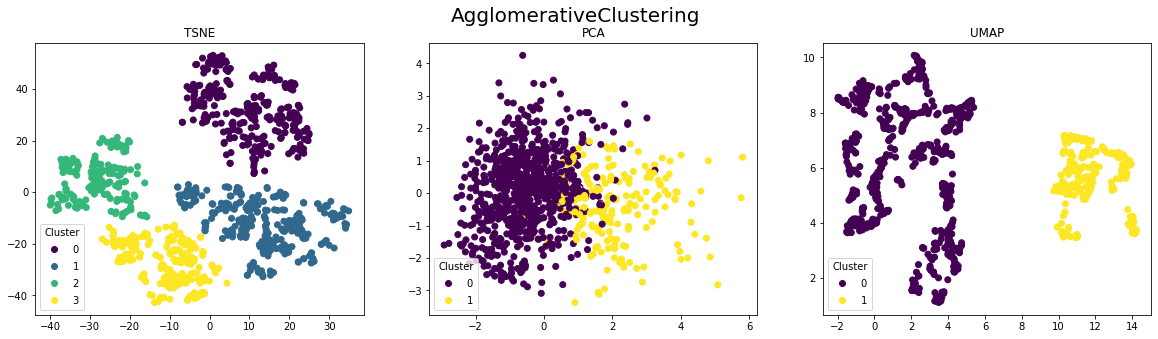

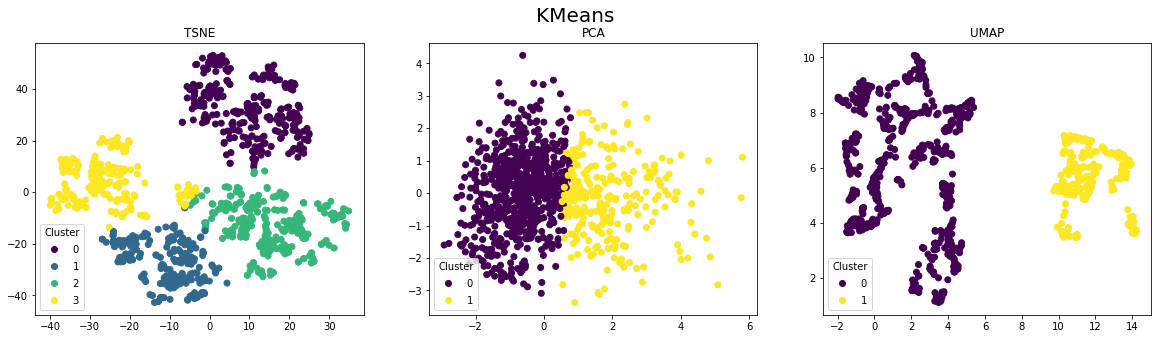

In [12]:
# Создадим цикл, перебирающий алгоритмы кластеризации, выбор оптимального количества кластеров и алгоритмы снижения размерности
clustering_algorithms = [AgglomerativeClustering, KMeans]
df_labels = pd.DataFrame()
n_clusters_list = [i for i in range(2, 21)]

for algorithm in clustering_algorithms:
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ind, dim_reducer in enumerate([TSNE, PCA, UMAP]):
        dim_reduced_data = dim_reducer(random_state=42).fit_transform(scaled_data)
        
        silhouette = []
        for i in n_clusters_list:
            model = algorithm(n_clusters=i).fit(dim_reduced_data)
            labels = model.labels_
            # Используем silhouette для подбора числа кластеров
            score = silhouette_score(dim_reduced_data, labels)
            silhouette.append(score)
        
        model = algorithm(n_clusters=n_clusters_list[np.argmax(silhouette)]).fit(dim_reduced_data)
        labels = model.labels_
        df_labels[algorithm.__name__+"_"+dim_reducer.__name__] = model.labels_
        plt.suptitle(algorithm.__name__, fontsize=20)
        scatter = axes[ind].scatter(dim_reduced_data[:, 0], dim_reduced_data[:, 1], c=labels)
        axes[ind].set_title(dim_reducer.__name__)
        legend = axes[ind].legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster")

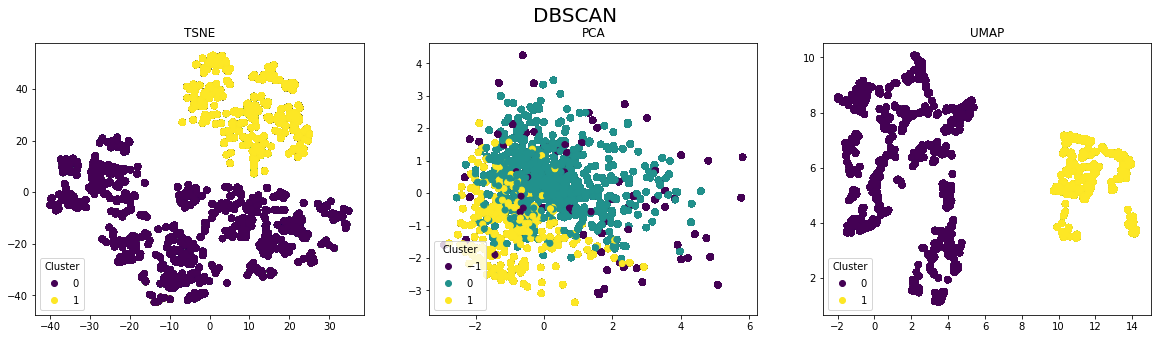

In [13]:
# Тамже оц
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for ind, dim_reducer in enumerate([TSNE, PCA, UMAP]):
    silhouette = []
    clusters = []
    dim_reduced_data = dim_reducer(random_state=42).fit_transform(scaled_data)
    eps_range = np.arange(0.1,10,0.05)
    for i in eps_range:
        dbscan = DBSCAN(eps=i).fit(dim_reduced_data)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            # Используем silhouette для подбора числа кластеров
            score = silhouette_score(dim_reduced_data, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
        model = DBSCAN(eps=eps_range[np.argmax(silhouette)]).fit(dim_reduced_data)
        labels = model.labels_
        df_labels['DBSCAN_' + dim_reducer.__name__] = model.labels_
        plt.suptitle('DBSCAN', fontsize=20)
        scatter = axes[ind].scatter(dim_reduced_data[:, 0], dim_reduced_data[:, 1], c=labels)
        axes[ind].set_title(dim_reducer.__name__)
        legend = axes[ind].legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster")

In [14]:
df_labels.head() # посмотрим получившие метки кластеров для разных алгоритмов

,AgglomerativeClustering_TSNE,AgglomerativeClustering_PCA,AgglomerativeClustering_UMAP,KMeans_TSNE,KMeans_PCA,KMeans_UMAP,DBSCAN_TSNE,DBSCAN_PCA,DBSCAN_UMAP
0,2,0,0,3,0,0,0,0,0
1,0,0,1,0,1,1,1,1,1
2,3,0,0,1,0,0,0,0,0
3,2,1,0,3,1,0,0,0,0
4,2,1,0,3,1,0,0,0,0


In [15]:
# Для дальнейшего анализа возьмём кластеры получившиеся из AgglomerativeClustering с использованием TSNE
alg = 'AgglomerativeClustering_TSNE'
df = df.join(df_labels[alg])

In [16]:
df = df.rename(columns={alg: "Cluster"})

In [17]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Cluster
0,67,1,2,2,2,1,1169,6,2,2
1,22,2,2,2,1,2,5951,48,2,0
2,49,1,1,2,1,2,2096,12,4,3
3,45,1,2,3,1,1,7882,42,5,2
4,53,1,2,3,1,1,4870,24,6,2


In [18]:
for i in df.columns:
    print(i,"-",np.mean(df[i]))

Age - 35.546
Sex - 1.31
Job - 1.904
Housing - 1.929
Saving accounts - 1.556
Checking account - 1.789
Credit amount - 3271.258
Duration - 20.903
Purpose - 4.576
Cluster - 1.3


<AxesSubplot:xlabel='Cluster', ylabel='Duration'>

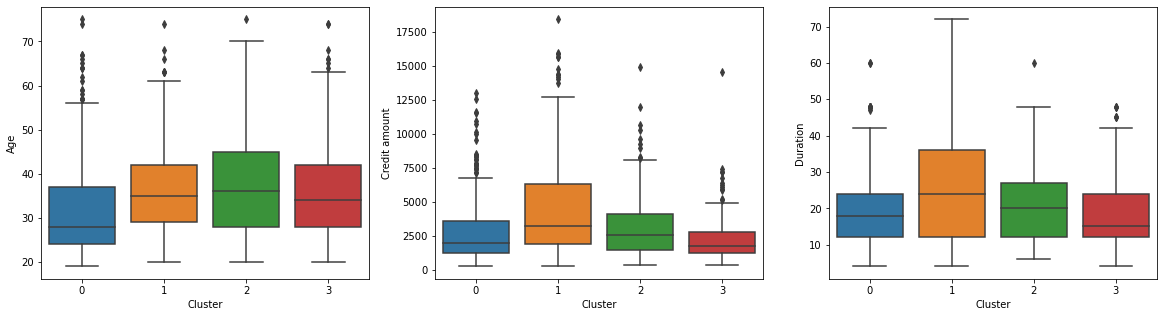

In [19]:
# Декодируем числа в признаки
df['Sex'] = df['Sex'].replace([1, 2], ['male','female'])
df['Checking account'] = df['Checking account'].replace([1, 2, 3], ['little','moderate','rich'])
df['Saving accounts'] = df['Saving accounts'].replace([1, 2, 3, 4], ['little','moderate','quite rich', 'rich'])
df['Housing'] = df['Housing'].replace([1, 2, 3], ['rent','own', 'free'])
df['Purpose'] = df['Purpose'].replace([i+1 for i in range(len(sorted_purposes))], sorted_purposes)

# Оценим численные признаки в зависимости от кластеров
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
sns.boxplot(y='Age', x='Cluster', data=df, ax=axes[0])
sns.boxplot(y='Credit amount', x='Cluster', data=df, ax=axes[1])
sns.boxplot(y='Duration', x='Cluster', data=df, ax=axes[2])

<AxesSubplot:xlabel='Checking account', ylabel='Cluster'>

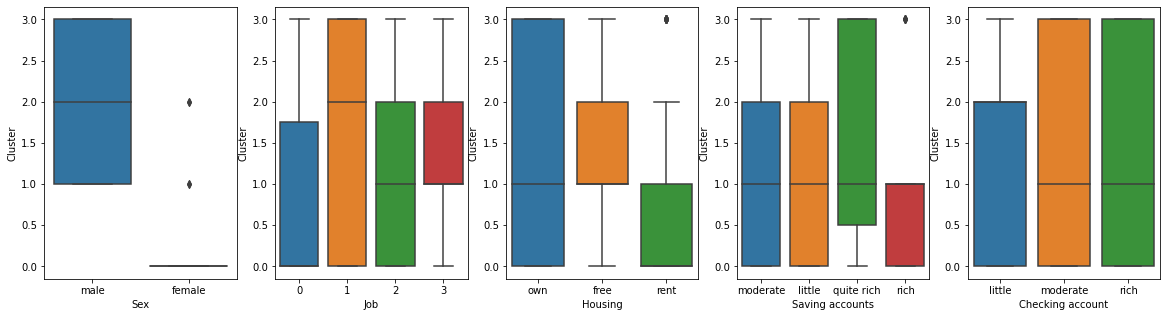

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
# Оценим категориальные признаки в зависимости от кластеров
sns.boxplot(x='Sex', y='Cluster', data=df, ax=axes[0])
sns.boxplot(x='Job', y='Cluster', data=df, ax=axes[1])
sns.boxplot(x='Housing', y='Cluster', data=df, ax=axes[2])
sns.boxplot(x='Saving accounts', y='Cluster', data=df, ax=axes[3])
sns.boxplot(x='Checking account', y='Cluster', data=df, ax=axes[4])

# Некоторые признаки оценим на гистограммах

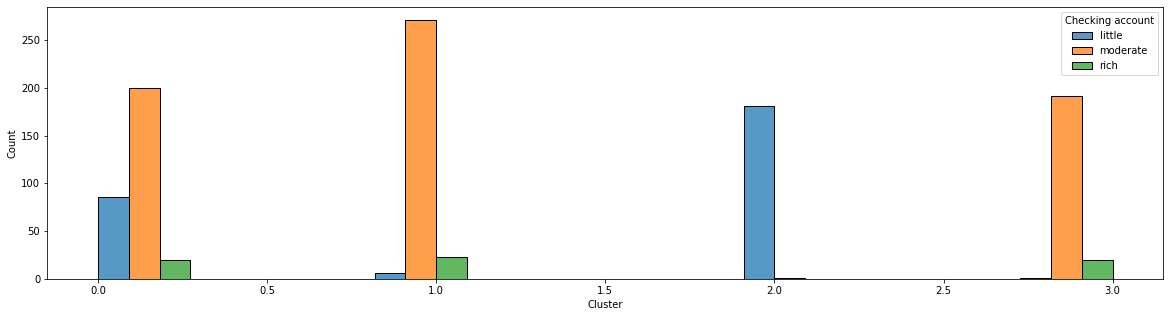

In [21]:
fig, axes = plt.subplots(figsize=(20, 5))
hist = sns.histplot(hue='Checking account', x='Cluster', data=df, multiple="dodge")
plt.show()

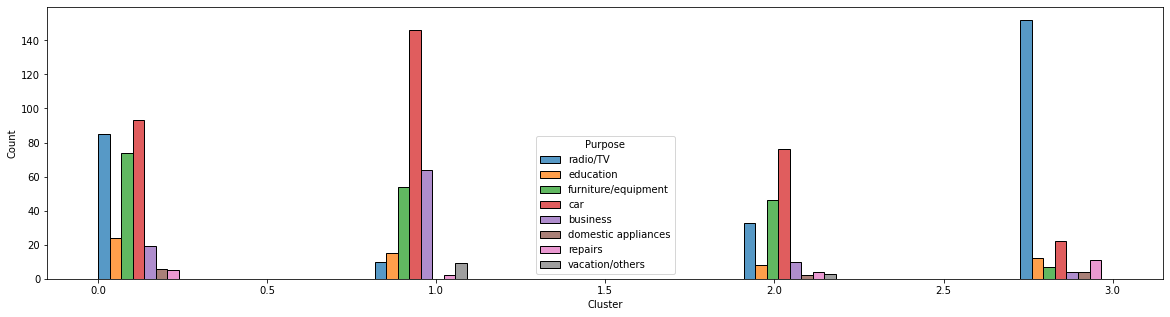

In [22]:
fig, axes = plt.subplots(figsize=(20, 5))
hist = sns.histplot(hue='Purpose', x='Cluster', data=df, multiple="dodge")
plt.show()

# Ещё раз посмотрим на кластеры

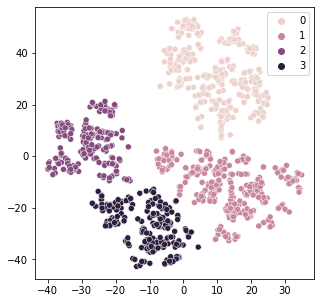

In [23]:
dim_reduced_data = TSNE(random_state=42).fit_transform(scaled_data)
model = AgglomerativeClustering(n_clusters=4).fit(dim_reduced_data)
labels = model.labels_

fig, axes = plt.subplots(figsize=(5, 5))
scatter = sns.scatterplot(x=dim_reduced_data[:, 0], y=dim_reduced_data[:, 1], hue=labels)

# Построим scatter на основе признаков отличающих одни кластеры от других

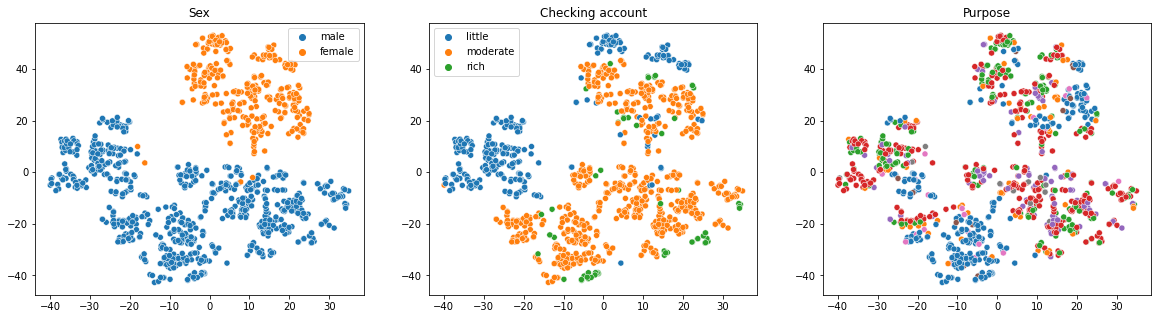

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].set_title('Sex')
axes[1].set_title('Checking account')
axes[2].set_title('Purpose')
scatter1 = sns.scatterplot(x=dim_reduced_data[:, 0], y=dim_reduced_data[:, 1], hue=df['Sex'].tolist(), ax=axes[0])
scatter2 = sns.scatterplot(x=dim_reduced_data[:, 0], y=dim_reduced_data[:, 1], hue=df['Checking account'].tolist(), ax=axes[1])
scatter3 = sns.scatterplot(x=dim_reduced_data[:, 0], y=dim_reduced_data[:, 1], hue=df['Purpose'].tolist(), ax=axes[2], legend=False)

# Анализ
Проанализируем полученные данные. Чётко видно, что кластеры разделились по полу. В нулевой кластер попали только женщины, в остальные, в большинстве случаев, мужчины. Чётко выделяется кластер, в который попали мужчины с целью кредита "car", величина кредита здесь в среднем наибольшая, как и продолжительность выплат. Также мы наблюдаем, что в третий кластер попало много людей с целью кредита "radio/TV" (это всё еще мужчины). Во второй класс попали мужчины у которых мало денег на текущих счетах

# Заключение

В результате анализа, удалось интерпретировать следующие условные кластеры:

0. Женщины с различными целями кредита;
1. Мужчины увлекающиеся машинами;
2. Мужчины увлекающие теле-/радио- электроникой;
3. Мужчины с малым количеством денег на текущих счетах, с различными целями кредита.